# Лабораторная работа №1 Numpy-имплементация многослойной нейронной сети

### Вариант - 3

### Цель работы

реализовать нейронную сеть и обучить ее с помощью метода обратного распространения ошибки.

### Задачи 

 - реализовать нейронную сеть на основе numpy;
 - обучить созданную нейронную сеть.

In [1]:
import numpy as np

Сначала определим базовый класс Layer с основными методами .forward() и .backward().

In [2]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # An identity layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Дальнейший план

В этом задании необходимо построить нейросеть для классификации рукописных цифр. Для этого понадобится реализовать следующее:
- ReLU слой
- Полносвязный слой, $f(X)=W \cdot X + b$
- Функцию потерь, для задачи классификации - cross-entropy
- Алгоритм обратного распространения ошибки

Далее нам будет необходимо реализовать каждый из пунктов выше, пользуяюсь предоставленными шаблонами кода.

### ReLU слой
В этом слое применяется поэлементная нелинейность $f(X)=max(X,0)$. В этом слое необходимо реализовать только .forward() метод.

In [3]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        
        output = np.maximum(0, input) # <-- My code here
        
        return output
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad_mask = input > 0
        return grad_output * relu_grad_mask

Для отладки градиентов, вычисленных аналитически, рекомендуется использовать сравнение с градиентами, вычисленными численно, как рассказывалось на лекции. Если вы корректно реализовали методы .forward() и .backward(), то значения градиентов окажутся достаточно близкими. Функция численного подсчета градиентов скопирована из файла util.py

In [4]:
"""Some auxiliary files used for honor track numpy assignment"""


import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/ (our ysda course).
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [5]:
import sys
import os
import time

import numpy as np

def load_mnist(flatten=False):
    """taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0],-1])
        X_val = X_val.reshape([X_val.shape[0],-1])
        X_test = X_test.reshape([X_test.shape[0],-1])

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
import matplotlib.pyplot as plt
def plot_embedding(X, y):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])

Проведём тестирование градиентов
1. Для этого создадим линейно распределённй набор точек points и инициализируем экземпляр слоя ReLU
2. Вычисляется градиент аналитически через метод backward слоя ReLU
3. Вычисляется численный градиент функции потерь по входу слоя с использованием функции eval_numerical_gradient. Это делается для проверки правильности аналитического градиента. Функция eval_numerical_gradient аппроксимирует градиенты, используя концепцию конечных разностей.
4. Проверяется, что аналитически вычисленный градиент (grads) и численно вычисленный градиент (numeric_grads) близки друг к другу с определенной погрешностью (np.allclose с параметрами rtol=1e-3 и atol=0). Это служит подтверждением корректности реализации обратного распространения для слоя ReLU.

In [7]:
points = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(points, np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=points)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

## Полносвязный слой


У полносвязного слоя есть обучаемые параметры: матрица линейного преобразования и столбец свободных членов.

$$f(X)= W \cdot X + b $$

* X - матрица входных данных размера [batch_size, num_features],
* W - матрица преобразования размера [num_features, num_outputs] 
* b - столбец свободных членов размера [num_outputs]

W и b необходимо инициализировать во время создания слоя и обновлять при каждом вызове метода .backward().
Для этого слоя вам необходимо реализовать как прямой, так и обратный проход. Формулы для аналитического подсчета градиентов можно взять из лекции, но рекомендуется проверить их самостоятельно на бумаге.

Реализуем полносвязный слой. Для этого опишем методы прямого и обратного прохода.

In [8]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.sum(axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Тестирование полносвязного слоя

Три следующих блока тестируют вашу реализацию, если все корректно, вы трижды получите "Well done!"Протестируем получившийся полносвязный слой

In [9]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [10]:
# To test the grads, we use gradients obtained via finite differences

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [11]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


## Функция потерь

In [13]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [14]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

## Итоговая нейросеть

Примеры того, что мы буем классифицировать

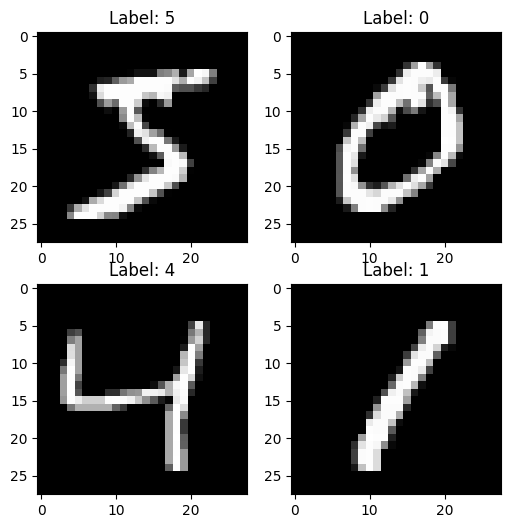

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

В нашей реализации сеть - просто список (Python-list) слоев. 

In [16]:
network = []
hidden_layers_size = 40
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))

Реализуем прямой проход по целой сети, последовательно вызывая .forward() для каждого слоя.

In [18]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

In [19]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
        
    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates

    return np.mean(loss)

Все готово для запуска обучения. Если все реализовано корректно, то точность классификации на валидационном множестве должна превысить 97%.

In [20]:
from tqdm.auto import tqdm
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

C:\Users\maksi\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Начинаем обучение

In [21]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 14
Train accuracy: 0.98798
Val accuracy: 0.9672


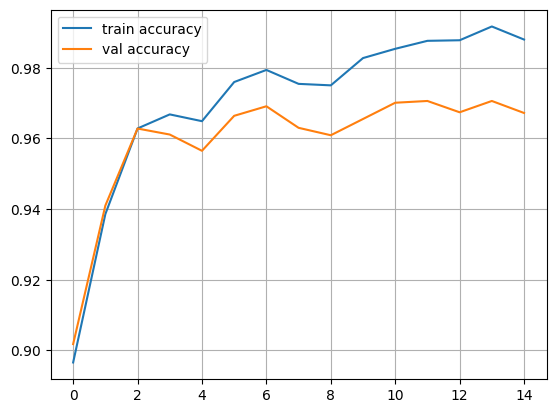

In [22]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Нейросеть для извлечения представлений
Помимо собственно классификации, нейросети часто используют для получения векторных описаний (embeddings) объектов различной природы. Часто в качестве представлений можно взять просто векторы активаций нейронов с одного из последних слоев. Вычислим такие представления:

In [23]:
train_activations = forward(network, X_train)
train_hidden_representations = train_activations[2]
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]

Полученные представления можно использовать в любых целях, в комбинации с другими инструментами машинного обучения.
Сравним обученные представления для изображений из MNIST c исходными 784-мерными представлениями. Построим t-SNE визуализации 1000 случайных изображений из X_train, полученные на основе исходных 784-мерных представлений и обученных представлений. Сделаем вывод о качестве представлений.

In [24]:
from sklearn.manifold import TSNE
subset_ids = np.random.permutation(X_train.shape[0])[:1000]

x_original = X_train[subset_ids]
x_learnt = train_hidden_representations[subset_ids]
x_original_tsne = TSNE(n_components=2).fit_transform(x_original)
x_learnt_tsne = TSNE(n_components=2).fit_transform(x_learnt)


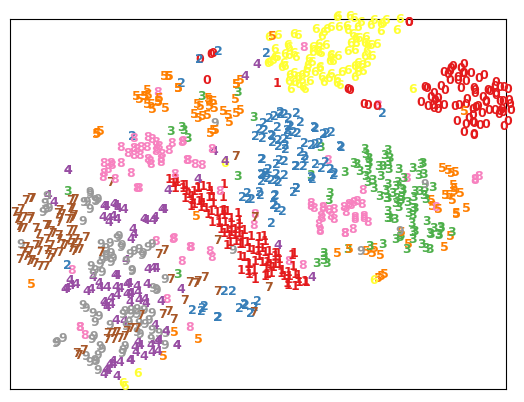

In [25]:
plot_embedding(x_original_tsne, y_train[subset_ids])

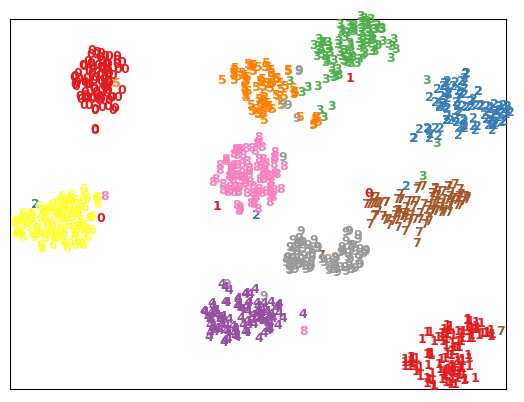

In [26]:
plot_embedding(x_learnt_tsne, y_train[subset_ids])

Наконец, исследуем универсальность полученных представлений. Используем их для решения другой задачи классификации: предсказание четности изображенной цифры.

In [27]:
new_y_train = y_train % 2
new_y_test = y_test % 2

Обучим простейшую логистическую регресиию, предсказывающую четность изображенной цифры, используя в качестве вектора признаков:

1) исходные 784-мерные представления

2) обученные представления

Сравним качество и сделайте вывод об универсальности обученных представлений.

In [28]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs")


# Использование обученных представлений для тренировочного и тестового набора
train_repr = train_hidden_representations
test_repr = test_hidden_representations

lr.fit(train_repr, new_y_train)

# Оценка точности на тестовом наборе
accuracy = lr.score(test_repr, new_y_test)
print(f"Accuracy of parity prediction: {accuracy}")

Accuracy of parity prediction: 0.9423


C:\Users\maksi\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* train_hidden_representations и test_hidden_representations являются матрицами, содержащими векторы активаций скрытого слоя нейронной сети для обучающего и тестового наборов данных соответственно. Эти представления извлекаются из нейронной сети после ее обучения и служат в качестве входных данных (признаков) для логистической регрессии. В данном случае, они представляют собой "извлеченные признаки" или "выученные представления" изображений, которые отражают внутреннее представление данных, выработанное нейронной сетью.
* Создается и обучается модель LogisticRegression из библиотеки sklearn. В качестве входных данных используются вышеупомянутые обученные представления (train_repr для обучающего набора), а в качестве меток — new_y_train, которые представляют собой значения четности цифр (0 для четных, 1 для нечетных).
* После обучения модели проверяется ее точность на тестовом наборе данных с использованием метода score. Метод score автоматически делает предсказания на основе test_repr (обученных представлений тестового набора) и сравнивает их с истинными метками new_y_test (значения четности для тестового набора). Результат — это доля правильно предсказанных меток от общего числа примеров в тестовом наборе, которая и печатается в качестве точности предсказания четности.

## Контрольные вопросы

**1.**  Биологический и искусственный нейрон. Основные функции активации нейронов.

Биологический и искусственный нейрон имеют сходства в том, что оба они служат основными строительными блоками для соответствующих систем: нервной системы в организмах и нейронных сетей в области искусственного интеллекта. Однако механизмы их работы существенно отличаются.

### Биологический нейрон

Биологический нейрон — это клетка нервной системы, способная принимать, обрабатывать и передавать электрохимические сигналы. Основные части биологического нейрона включают:

- **Дендриты**: принимают сигналы от других нейронов.
- **Тело клетки (сома)**: содержит ядро и основные жизненно важные элементы клетки; здесь сигналы от дендритов суммируются.
- **Аксон**: передает сигналы от тела клетки к другим нейронам или мышечным клеткам.
- **Синапсы**: контактные точки между аксоном одного нейрона и дендритами другого, через которые происходит передача сигналов.

### Искусственный нейрон

Искусственный нейрон — это математическая модель, вдохновленная работой биологического нейрона. Он принимает несколько входных сигналов, обрабатывает их и выдает один выходной сигнал. Структура искусственного нейрона включает:

- **Входы (x)**: соответствуют дендритам и представляют данные, подаваемые на нейрон.
- **Веса (w)**: числовые коэффициенты, применяемые к входным данным, аналогичны синаптической силе в биологическом нейроне.
- **Сумматор**: суммирует входные данные, умноженные на веса, аналогично суммации в теле клетки.
- **Функция активации**: преобразует суммарный сигнал в выходной сигнал нейрона.

### Основные функции активации

Функция активации определяет, насколько активен нейрон в ответ на полученные входные данные. Некоторые из основных функций активации включают:

- **Линейная**: $(f(x) = x)$. Простейшая функция, пропускающая сигнал без изменений.
- **Сигмоид**: $(f(x) = \frac{1}{1 + e^{-x}})$. Преобразует входной сигнал в значения в диапазоне от 0 до 1, полезно для задач бинарной классификации.
- **Гиперболический тангенс (tanh)**: $(f(x) = \tanh(x))$. Выводит значения в диапазоне от -1 до 1, центрированных вокруг нуля.
- **ReLU (Rectified Linear Unit)**: $(f(x) = \max(0, x))$. Одна из наиболее популярных функций активации для глубокого обучения, неактивна для отрицательных значений и линейна для положительных.
- **Leaky ReLU**: $(f(x) = \max(\alpha x, x))$. Вар

иация ReLU, позволяющая передавать небольшой градиент для отрицательных значений, предотвращая "умершие" нейроны.
- **Softmax**: применяется в выходном слое для многоклассовой классификации, преобразует входные значения в распределение вероятностей по классам.

Каждая из этих функций активации имеет свои особенности и области применения в зависимости от задачи и структуры нейронной сети.

--------

**2.** Преимущества нейронных сетей. 

Нейронные сети, особенно глубокие нейронные сети (Deep Neural Networks, DNNs), предоставляют множество преимуществ при решении различных задач в области искусственного интеллекта и машинного обучения. Вот некоторые ключевые преимущества нейронных сетей:

1. Способность к обучению и адаптации
Нейронные сети могут автоматически и эффективно извлекать и учиться сложным зависимостям в данных без необходимости явного программирования или ручного создания правил.

2. Обработка больших объемов данных
Благодаря своей архитектуре нейронные сети способны обрабатывать и анализировать большие объемы данных, что делает их идеальными для задач, связанных с большими данными и комплексным анализом.

3. Универсальность
Нейронные сети применимы к широкому спектру задач, включая классификацию изображений, распознавание речи, машинный перевод, рекомендательные системы и многое другое.

4. Автоматическое извлечение признаков
В отличие от традиционных методов машинного обучения, где необходимо вручную разрабатывать признаки, нейронные сети способны автоматически извлекать сложные признаки из сырых данных.

5. Обработка неструктурированных данных
Нейронные сети могут работать с неструктурированными или полуструктурированными данными, такими как тексты, изображения и аудио, что расширяет их возможности применения.

6. Параллелизм
Благодаря своей архитектуре нейронные сети хорошо поддаются параллельной обработке, что позволяет значительно ускорить их тренировку и инференс с помощью современных графических процессоров (GPU).

7. Продолжительное обучение
Нейронные сети могут продолжать обучаться и улучшаться по мере появления новых данных, что делает их адаптивными к изменениям и способными к непрерывному улучшению производительности.

8. Работа с нечеткостью и неопределенностью
Нейронные сети могут обрабатывать нечеткую и неопределенную информацию, что делает их подходящими для задач, где данные неполные или содержат шум.

9. Улучшение производительности с ростом объема данных
В отличие от некоторых традиционных алгоритмов, производительность нейронных сетей обычно улучшается с увеличением объема доступных тренировочных данных.

10. Перенос обучения (Transfer Learning)
Модели, обученные на одной задаче, могут быть адаптированы для решения других, схожих задач, что снижает необходимость в больших объемах данных для каждой новой задачи.

Несмотря на все преимущества, нейронные сети также имеют свои ограничения и вызовы, такие как потребность в больших объемах данных для эффективного обучения, сложность интерпретации моделей, риск переобучения, и высокие требования к вычислительным ресурсам. Тем не менее, благодаря их способности к обучению сложным закономерностям в данных и гибкости в применении к различным задачам, нейронные сети продолжают оставаться на переднем крае развития искусственного интеллекта и машинного обучения.

Таким образом, нейронные сети представляют собой мощный инструмент для решения широкого спектра задач, от автоматического распознавания образов до обработки естественного языка и за его пределами. Их способность адаптироваться и улучшаться с поступлением новой информации делает их неоценимым активом в быстро меняющемся мире данных и технологий.

---------

**3.** Классификации нейронных сетей, области применения и решаемые задачи. Основные направления развития нейрокомпьютинга.

Нейронные сети — это мощные инструменты, которые могут быть применены к широкому спектру задач в различных областях. Они классифицируются на основе их архитектуры, специфики обучения и типа задач, которые они решают. Ниже представлена классификация нейронных сетей, их области применения и основные направления развития нейрокомпьютинга.

### Классификация нейронных сетей

1. **По архитектуре:**
   - **Полносвязные нейронные сети (Fully Connected Neural Networks, FCNNs)**: Все нейроны в одном слое соединены с каждым нейроном в следующем слое.
   - **Сверточные нейронные сети (Convolutional Neural Networks, CNNs)**: Используются для анализа визуальных образов, применяют свертки вместо обычных матричных умножений в одном или нескольких слоях.
   - **Рекуррентные нейронные сети (Recurrent Neural Networks, RNNs)**: Подходят для работы с последовательными данными (например, текстом или временными рядами), имеют "память" о предыдущих входах.
   - **Генеративно-состязательные сети (Generative Adversarial Networks, GANs)**: Состоят из двух сетей, соревнующихся друг с другом: генератора, создающего данные, и дискриминатора, пытающегося отличить настоящие данные от сгенерированных.

2. **По типу обучения:**
   - **С учителем (Supervised Learning)**: Обучение на парах "вход-выход", где правильный ответ заранее известен.
   - **Без учителя (Unsupervised Learning)**: Обучение только на входных данных без явных ответов, цель — найти структуру в данных.
   - **С подкреплением (Reinforcement Learning)**: Обучение на основе взаимодействия с окружающей средой и получения наград за выполнение целевых действий.

### Области применения и решаемые задачи

- **Компьютерное зрение**: Распознавание образов, классификация изображений, сегментация объектов, анализ видео.
- **Обработка естественного языка (Natural Language Processing, NLP)**: Машинный перевод, генерация текста, распознавание речи, анализ тональности.
- **Рекомендательные системы**: Предложение продуктов или контента пользователям на основе их интересов и истории поведения.
- **Игры и симуляции**: Обучение ИИ для игр, моделирование реальных сценариев.
- **Медицина**: Диагностика заболеваний на основе медицинских изображений, прогнозирование течения болезней.
- **Финансы**: Анализ рынка, управление рисками, автоматизированная торговля.

### Основные направления развития нейрокомпьютинга

1. **Улучшение алгоритмов обучения**: Разработка новых методов для ускорения обучения и повышения эффективности нейронных сетей.
2. **Интерпретируемость и прозрачность моделей**: Создание методов, позволяющих понимать, как нейронные сети принимают решения.
3. **Энергоэффективность**: Разработка архитектур и аппаратных решений для снижения энергопотребления при обучении и использовании нейронных сетей.
4. **Нейроморфные вычисления**: Разработка вычислительных систем, имитирующих структуру и принципы работы мозга.
5. **Перенос обучения и мультизадачность**: Создание моделей, способных обучаться на одной задаче и эффективно применять полученные знания для решения других задач.
6. **Разработка новых типов нейронных сетей**: Исследование новых архитектур, способных еще эффективнее решать существующие и новые задачи.

Нейронные сети и нейрокомпьютинг продолжают развиваться, открывая новые возможности для искусственного интеллекта и машинного обучения.